In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from ml_collections import ConfigDict

from mlp2gcnn import fakeGCNN as fakeGCNN_Z2
from mlp2gcnn_P4 import fakeCNN as fakeGCNN_P4
from gcov2d_for_learn import P4ConvZ2
from gcov2d_for_learn import P4ConvP4

import os.path as path
import math

torch.manual_seed(25)
CKPT_PATH = "results/checkpoints"

In [2]:
def cnn_dim_out(in_size, ker, stride, padding):
    return math.floor((in_size - ker + 2 * padding)/stride)+1

def prepare_dataset():
    train_split = MNIST("dataset", train=True, download=True, transform=ToTensor())
    test_split = MNIST("dataset", train=False, transform=ToTensor())
    train_loader = DataLoader(train_split, batch_size=10, shuffle=True)
    test_loader = DataLoader(test_split, batch_size=10, shuffle=True)
    # train_split.train_data.to(torch.device("cuda:0"))
    # test_split.train_data.to(torch.device("cuda:0"))
    # train_split.train_labels.to(torch.device("cuda:0"))
    # test_split.train_labels.to(torch.device("cuda:0"))
    return train_loader, test_loader

def plot_results(mlp_out, cnn_out=None):

    if cnn_out is None:
        f, axarr = plt.subplots(1,4, figsize=(16, 8))
        for i in range(4):
            axarr[i].imshow(mlp_out[i].detach().cpu().numpy(), cmap='gray')
            axarr[i].axis(False)
            axarr[1, i].set_title(f"MLP output channel {i + 1}")

        plt.subplots_adjust(left=0.05, right=0.8, wspace=0.2)
        plt.show()
    else:
        vmin = min(cnn_out.min(), mlp_out.min())
        vmax = max(cnn_out.max(), mlp_out.max())

        f, axarr = plt.subplots(2,4, figsize=(16, 8))
        for i in range(4):
            axarr[1, i].imshow(cnn_out[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, cmap='gray')
            axarr[1, i].axis(False)
            axarr[1, i].set_title(f"P4ConvZ2 output channel {i + 1}")

        for i in range(4):
            axarr[0, i].imshow(mlp_out[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, cmap='gray')
            axarr[0, i].axis(False)
            axarr[0, i].set_title(f"MLP output channel {i + 1}")

        plt.subplots_adjust(left=0.05, right=0.8, wspace=0.2)
        plt.show()

In [3]:
cfg = ConfigDict()
cfg.name = 'mlp2gcnn'
cfg.root_dir = "/project/a/aspuru/chengl43/rot_equiv_exp"
cfg.log_dir = f"{cfg.root_dir}/logs/"
# cfg.seed = 42 
cfg.seed = 10000
cfg.max_iters = 10000
cfg.grad_norm_clip = 1.0
cfg.lr = 1e-2
cfg.img_dim = 28
cfg.stride = 1
cfg.kernel_size = 3
cfg.ss_gamma = 2.0
cfg.bs = 1
cfg.activation = 0

cfg.in_dim = cfg.img_dim ** 2
cfg.out_dim = cnn_dim_out(cfg.img_dim, 3, 1, 0) ** 2
cfg.hidden_dim = 32
cfg.blocks = 9
cfg.layers = 1
cfg.block_output_dim = cnn_dim_out(cfg.img_dim, 3, 1, 0) ** 2
cfg.merge_dim = 10

cparams_Z2 = torch.rand(9).cuda()
img = torchvision.io.read_image("dataset/small_MNIST/1/2.jpg").cuda()
img = img.type(torch.float32)
modelZ2 = fakeGCNN_Z2(cfg).cuda()
convZ2 = P4ConvZ2(weight=cparams_Z2).cuda()

In [4]:
checkpoint = torch.load(path.join(CKPT_PATH, "Z2_9_28_checkpoint.ckpt"))
modelZ2.load_state_dict(checkpoint['model'])

<All keys matched successfully>

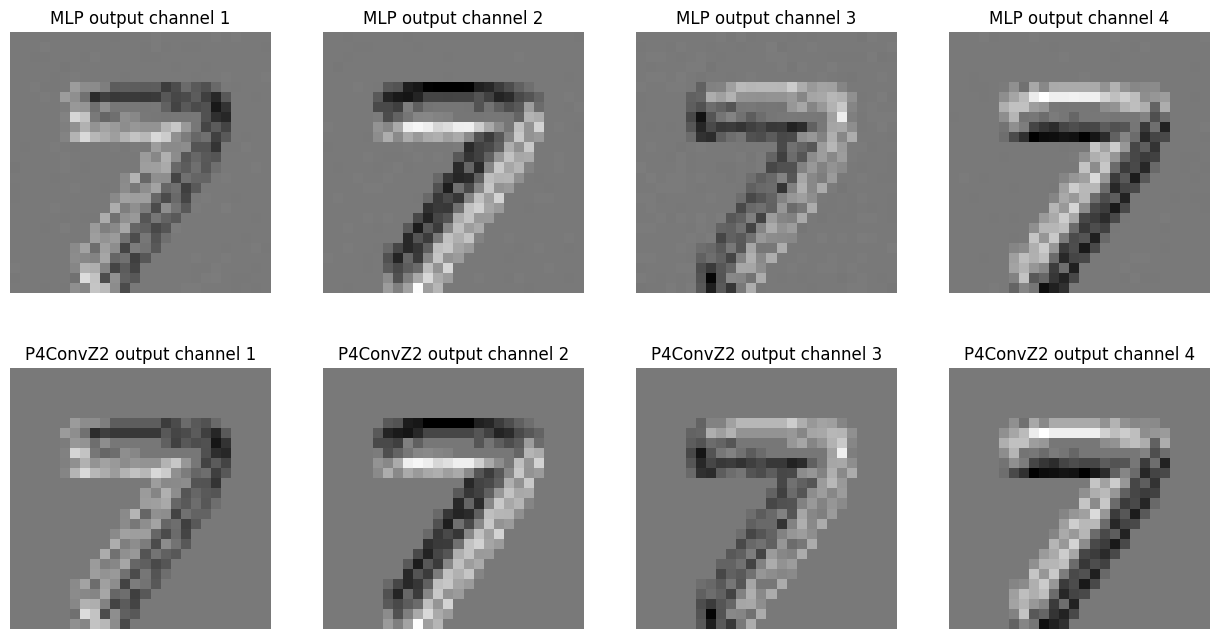

In [5]:
modelZ2.eval()

train_loader, test_loader = prepare_dataset()
sample = next(iter(train_loader))
img = sample[0][0].cuda()
label = sample[0][1]

mlp_out = modelZ2(img, cparams_Z2).squeeze()
cnn_out = convZ2(img).squeeze(0)

plot_results(mlp_out, cnn_out)

torch.Size([26, 26])


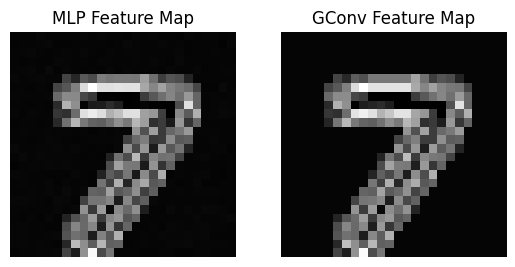

In [6]:
result_cnn = torch.max(cnn_out, axis=0)[0].squeeze()
result_mlp = torch.max(mlp_out, axis=0)[0].squeeze()
print(result_mlp.shape)
plt.subplot(1, 2, 1)
plt.imshow(result_mlp.reshape(26, 26).detach().cpu(), cmap='gray')
plt.title("MLP Feature Map")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(result_cnn.reshape(26, 26).detach().cpu(), cmap='gray')
plt.title("GConv Feature Map")
plt.axis("off")

plt.show()

In [8]:
cfg = ConfigDict()
cfg.name = 'mlp2gcnn'
cfg.root_dir = "/project/a/aspuru/chengl43/rot_equiv_exp"
cfg.log_dir = f"{cfg.root_dir}/logs/"
# cfg.seed = 42 
cfg.seed = 10000
cfg.max_iters = 10000
cfg.grad_norm_clip = 1.0
cfg.lr = 1e-2
cfg.img_dim = 26
cfg.stride = 1
cfg.kernel_size = 3
cfg.ss_gamma = 2.0
cfg.bs = 1
cfg.activation = 0

cfg.in_dim = cfg.img_dim ** 2 
cfg.out_dim = cnn_dim_out(cfg.img_dim, 3, 1, 0) ** 2
cfg.hidden_dim = 32
cfg.blocks = 9
cfg.layers = 1
cfg.block_output_dim = cnn_dim_out(cfg.img_dim, 3, 1, 0) ** 2
cfg.merge_dim = 10
cfg.provide_filter = 1
cfg.emb_dim = 20

cparams_P4 = torch.rand((1, 1, 4, 3, 3)).cuda()
modelP4 = fakeGCNN_P4(cfg).cuda()
convP4 = P4ConvP4(weight=cparams_P4)
checkpoint = torch.load("benchmark/checkpoints/9_26_P4_checkpoint.ckpt")
modelP4.load_state_dict(checkpoint['model'])

<All keys matched successfully>

torch.Size([1, 4, 576])
torch.Size([1, 4, 24, 24])
tensor(0.0495, device='cuda:0', grad_fn=<MseLossBackward0>)


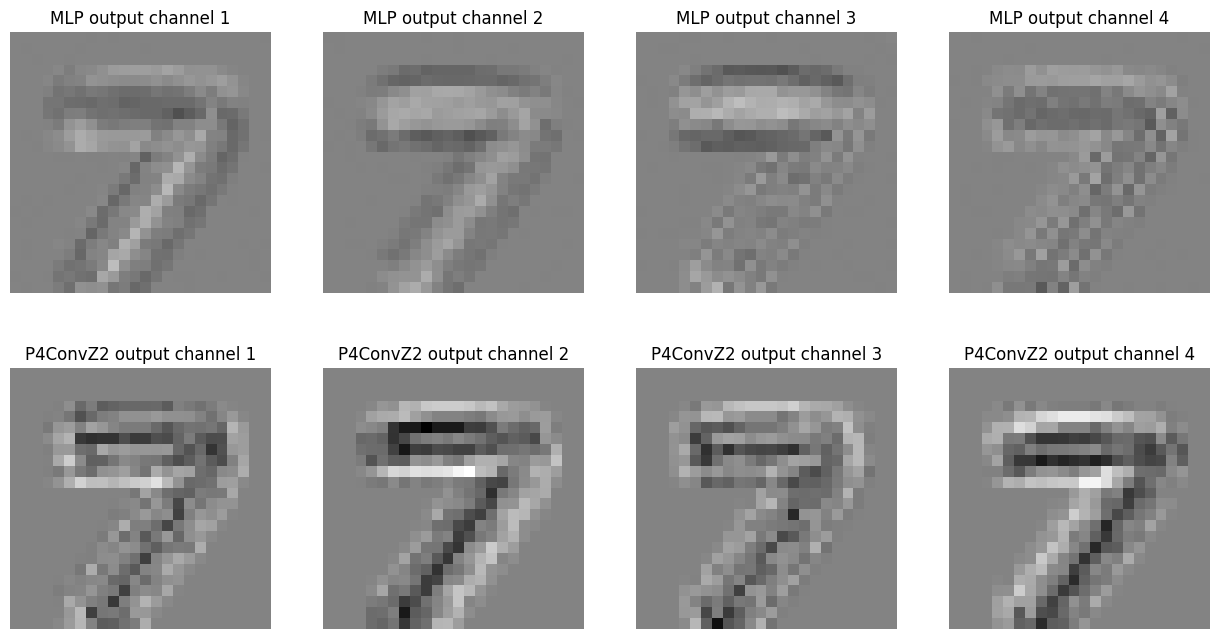

In [18]:

mlp_out_2 = modelP4(mlp_out.unsqueeze(0), cparams_P4.flatten())
cnn_out_2 = convP4(cnn_out.unsqueeze(0))
print(mlp_out_2.shape)
print(cnn_out_2.shape)
print(nn.MSELoss()(mlp_out_2.reshape(4, 24, 24), cnn_out_2.reshape(4, 24, 24)))

plot_results(mlp_out_2.reshape(4, 24, 24), cnn_out_2.reshape(4, 24, 24))

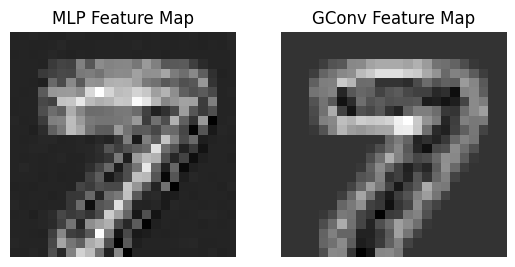

In [11]:
result_cnn = torch.max(cnn_out_2, axis=1)[0].squeeze()
result_mlp = torch.max(mlp_out_2, axis=1)[0].squeeze()

plt.subplot(1, 2, 1)
plt.imshow(result_mlp.reshape(24, 24).detach().cpu(), cmap='gray')
plt.title("MLP Feature Map")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(result_cnn.reshape(24, 24).detach().cpu(), cmap='gray')
plt.title("GConv Feature Map")
plt.axis("off")

plt.show()

In [12]:
from torchvision.transforms.functional import rotate

rot_input_90 = rotate(img, 90)
rot_input_180 = rotate(img, 180)
rot_input_270 = rotate(img, 270)
# images_np = np.array([img, rot_input_90, rot_input_180, rot_input_270])
images = torch.stack([img, rot_input_90, rot_input_180, rot_input_270]).cuda()
print(images.shape)

torch.Size([4, 1, 28, 28])


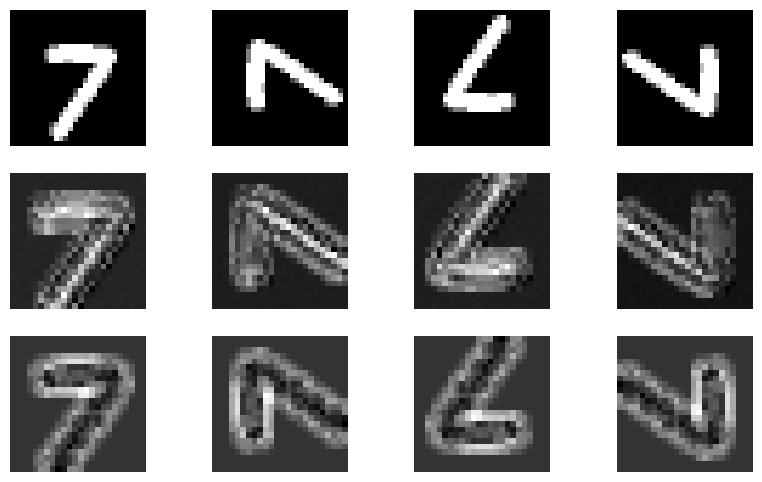

In [13]:
rot_output = modelP4(modelZ2(images, cparams_Z2), cparams_P4.flatten())
cnn_rot_output = convP4(convZ2(images))

mlp_result = torch.max(rot_output, axis=1)[0].reshape(4, 24, 24).detach().cpu()
cnn_result = torch.max(cnn_rot_output, axis=1)[0].reshape(4, 24, 24).detach().cpu()

f, axarr = plt.subplots(3, 4, figsize=(10, 6))

for i in range(4):
    axarr[0, i].imshow(images[i].squeeze().detach().cpu(), cmap='gray')
    axarr[0, i].axis('off')

for i in range(4):
    axarr[1, i].imshow(mlp_result[i].squeeze().detach().cpu(), cmap='gray')
    axarr[1, i].axis('off')

for i in range(4):
    axarr[2, i].imshow(cnn_result[i].squeeze().detach().cpu(), cmap='gray')
    axarr[2, i].axis('off')

# plt.subplots_adjust(left=0.05, right=0.8, wspace=0.1)
plt.show()

In [ ]:
rot_output = modelP4(modelZ2(rot_input, cparams_Z2).unsqueeze(0), cparams_P4.flatten())
cnn_rot_output = convP4(convZ2(rot_input))

plt.imshow(torch.sum(rot_output, axis=1).reshape(24, 24).detach().cpu(), cmap='gray')
plt.imshow(torch.sum(cnn_rot_output, axis=1).reshape(24, 24).detach().cpu(), cmap='gray')

plt.show()

NameError: name 'rot_input' is not defined

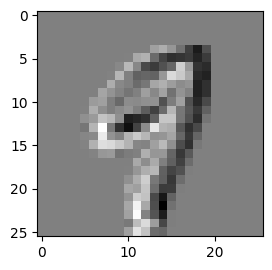

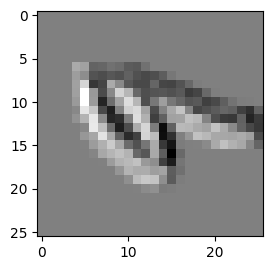

In [ ]:
conv_img = F.conv2d(img.reshape(1, 1, 28, 28), weight=cparams_Z2.reshape(1, 1, 3, 3))
rot_conv_img = F.conv2d(rot_input_90.reshape(1, 1, 28, 28), weight=cparams_Z2.reshape(1, 1, 3, 3))

plt.subplot(1, 2, 1)
plt.imshow(conv_img.squeeze().detach().cpu(), cmap='gray')
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(rot_conv_img.squeeze().detach().cpu(), cmap='gray')

plt.show()